In [2]:
# pip install tda-mapper tadasets plotly gudhi

In [2]:
import numpy as np
import gudhi as gd
import pandas as pd
import gudhi.representations
from tadasets import torus

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive

In [3]:
data_torus = torus(n=1500, c=3, a=1)

# fig = go.Figure(data=[go.Scatter3d(
#     x=data_torus[:,0],
#     y=data_torus[:,1],
#     z=data_torus[:,2],
#     mode='markers',
#     marker=dict(
#         size=2,
#         color=data_torus[:,2],  # 以z軸值為顏色
#         colorscale='Viridis',
#         opacity=0.8
#     )
# )])

# fig.update_layout(
#     scene = dict(
#         xaxis_title='X Label',
#         yaxis_title='Y Label',
#         zaxis_title='Z Label'
#     ),
#     width=700,
#     margin=dict(r=20, b=10, l=10, t=10)
# )

# fig.show()

In [4]:
lens = PCA(2).fit_transform(data_torus)

mapper_algo = MapperAlgorithm(
    cover=CubicalCover(
        n_intervals=10,
        overlap_frac=0.3),
    clustering=DBSCAN())
mapper_graph = mapper_algo.fit_transform(data_torus, lens)

mapper_plot = MapperLayoutInteractive(
    mapper_graph,
    colors=data_torus[:, 0],
    cmap='jet',
    agg=np.nanmean,
    dim=3,
    iterations=60,
    seed=42,
    width=600,
    height=600)

# fig_mean1 = mapper_plot.plot()
# fig_mean1.show(config={'scrollZoom': True})

## 建立Mapper每個node的資訊

In [5]:
x = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [5]:
full_info

,color,node,size,x,y,z,ids
0,-2,0,14,0.033472,-0.740029,0.202435,"[0, 1, 88, 612, 676, 757, 846, 1009, 1014, 114..."
1,-2,73,16,0.153827,-0.631377,0.181617,"[0, 271, 389, 393, 474, 523, 590, 621, 763, 82..."
2,-3,18,29,-0.015320,-0.858098,0.238118,"[1, 14, 121, 133, 158, 168, 237, 280, 365, 391..."
3,-3,58,36,-0.094396,-0.817995,0.201084,"[1, 88, 92, 93, 145, 157, 168, 222, 237, 263, ..."
4,-3,91,19,0.081207,-0.767066,0.261212,"[1, 207, 269, 286, 317, 387, 678, 750, 911, 94..."
...,...,...,...,...,...,...,...
108,2,99,10,0.853825,0.529160,0.167048,"[401, 408, 667, 717, 899, 959, 1002, 1060, 135..."
109,2,100,13,0.768543,0.507020,0.284068,"[449, 782, 793, 803, 868, 886, 910, 955, 1114,..."
110,3,44,12,0.522101,0.855564,0.097279,"[488, 769, 844, 877, 924, 1061, 1110, 1171, 11..."
111,-2,107,8,-0.338832,-0.774993,0.084423,"[494, 519, 925, 977, 1036, 1270, 1299, 1412]"


In [6]:
data_torus[:, :2]

array([[-2.59633889, -1.12909811],
       [-3.46528087, -1.09872293],
       [ 2.87391457, -1.41961734],
       ...,
       [ 1.49139607,  1.55396543],
       [-1.45067172, -3.600206  ],
       [ 0.78593419,  1.8614787 ]])

### 兩筆分別帶入points，可以分段了解Torus的架構，為什麼他有兩個hole，為什麼整筆資料有一個2-simplex

In [1]:
# data_torus[:, :2]
# data_torus[:, 1:3]

usetex mode requires TeX.


<AxesSubplot: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

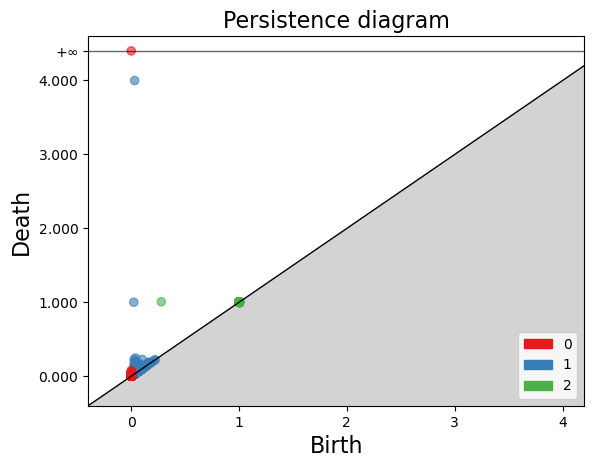

In [6]:
plt.rcParams['text.usetex'] = False
alpha_complex = gd.AlphaComplex(points=data_torus).create_simplex_tree()
# 計算持久
diag = alpha_complex.persistence()

gd.plot_persistence_diagram(diag)

In [7]:
LS = gd.representations.Landscape(resolution=1000)
L = LS.fit_transform([alpha_complex.persistence_intervals_in_dimension(1)])
L

array([[0.00025004, 0.00153527, 0.00455467, ..., 0.        , 0.        ,
        0.        ]])

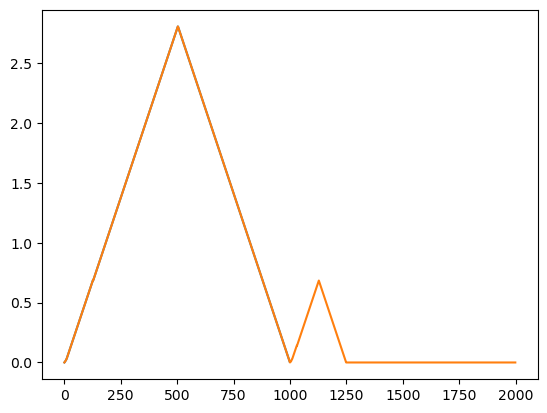

In [8]:
plt.plot(L[0][:1000])
plt.plot(L[0][:2000])
plt.show()